In [42]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as mg

import seaborn as sns
from matplotlib.patches import Patch
from PIL import Image
from scipy.stats import spearmanr, wilcoxon, gaussian_kde

plt.rcParams.update({
    "font.size": 9,
    "axes.titlesize": 11,
    "axes.labelsize": 10,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "figure.dpi": 150
})
sns.set_style("white")

In [22]:
# Epigept vs Corgi results (assay-level long table)
epigept_vs_corgi_path = "/project/deeprna/data/revision/epigept_benchmark_new/benchmark_results.tsv"

# Corgi vs Borzoi results (long table)
borzoi_vs_corgi_path = "/project/deeprna_data/corgi-reproduction/processed_data_extended/figure3/grt_vs_borzoi/correlation_results.csv"

# Corgi vs Borzoi gene level
genelevel_dir = '/project/deeprna_data/corgi-reproduction/processed_data_extended/figure3/gene_level_cross_region_genebody_vsborzoi'

# load
df_epigept = pd.read_csv(epigept_vs_corgi_path, sep='\t')
# Tisseu 124 epigept h3k4me3 and h3k27me3 are missing
df_epigept = df_epigept[~((df_epigept['tissue'] == 124) & (df_epigept['assay'].isin(['H3K4me3', 'H3K27me3'])))].copy()
df_borzoi = pd.read_csv(borzoi_vs_corgi_path)

MODEL_COLORS = {
    'Corgi': '#f28e2b',    # orange
    'EpiGePT': '#4e79a7',  # muted blue
    'Borzoi': '#59a14f'    # green
}

def map_assay_names(x):
    s = str(x).strip().lower()
    if s == 'dnase': return 'DNase'
    if s == 'atac': return 'ATAC'
    if s == 'ctcf': return 'CTCF'
    if s.startswith('cage'): return 'CAGE'
    if 'rna' in s and not s.startswith('rna_10x'): return 'RNA'
    if len(s) > 0 and s[0] == 'h': return 'Histone'
    return None

In [3]:
genes_df = pd.read_csv('/project/deeprna/data/Homo_sapiens.gene_info.tsv', sep='\t')
coding_genes = genes_df.loc[genes_df.type_of_gene == 'protein-coding', 'Symbol'].values

genes_corgi = pd.read_csv('/project/deeprna_data/corgi-reproduction/processed_data_extended/figure3/gene_level_cross_region_genebody_vsborzoi/all_expressions_corgi.csv', index_col=0)
genes_borzoi = pd.read_csv('/project/deeprna_data/corgi-reproduction/processed_data_extended/figure3/gene_level_cross_region_genebody_vsborzoi/all_expressions_borzoi.csv', index_col=0)
genes_encode = pd.read_csv('/project/deeprna_data/corgi-reproduction/processed_data_extended/figure3/gene_level_cross_region_genebody_vsborzoi/all_expressions_encode.csv', index_col=0)
# Skip every 2nd column
genes_encode = genes_encode.iloc[:, range(0, genes_encode.shape[1], 2)]

coding_genes_corgi = genes_corgi[genes_corgi.index.isin(coding_genes)]
coding_genes_borzoi = genes_borzoi[genes_borzoi.index.isin(coding_genes)]
coding_genes_encode = genes_encode[genes_encode.index.isin(coding_genes)]

# # Filter out zero expression genes if zero across all samples
zero_genes = set()
for gene in coding_genes_corgi.index:
    if coding_genes_corgi.loc[gene].max() == 0 and coding_genes_borzoi.loc[gene].max() == 0 and coding_genes_encode.loc[gene].max() == 0:
        zero_genes.add(gene)

coding_genes_corgi_nonzero = coding_genes_corgi[~coding_genes_corgi.index.isin(zero_genes)]
coding_genes_borzoi_nonzero = coding_genes_borzoi[~coding_genes_borzoi.index.isin(zero_genes)]
coding_genes_encode_nonzero = coding_genes_encode[~coding_genes_encode.index.isin(zero_genes)]
print(len(coding_genes_corgi_nonzero), len(coding_genes_borzoi_nonzero), len(coding_genes_encode_nonzero))

734 734 734


In [4]:
borzoi_cors = []
corgi_cors = []
for i in range(coding_genes_corgi.shape[1]):
    r_borzoi, p_borzoi = spearmanr(coding_genes_borzoi.iloc[:, i], coding_genes_encode.iloc[:, i])
    r_corgi, p_corgi = spearmanr(coding_genes_corgi.iloc[:, i], coding_genes_encode.iloc[:, i])
    borzoi_cors.append(r_borzoi)
    corgi_cors.append(r_corgi)

print(f"Cross-region coding gene-level Spearman R: Borzoi mean={np.mean(borzoi_cors):.4f}, Corgi mean={np.mean(corgi_cors):.4f}, n={len(borzoi_cors)}, n_genes={coding_genes_corgi.shape[0]}")

borzoi_cors = []
corgi_cors = []
for i in range(coding_genes_corgi_nonzero.shape[1]):
    r_borzoi, p_borzoi = spearmanr(coding_genes_borzoi_nonzero.iloc[:, i], coding_genes_encode_nonzero.iloc[:, i])
    r_corgi, p_corgi = spearmanr(coding_genes_corgi_nonzero.iloc[:, i], coding_genes_encode_nonzero.iloc[:, i])
    borzoi_cors.append(r_borzoi)
    corgi_cors.append(r_corgi)

print(f"Cross-region coding gene-level Spearman R (excluding 0 expression genes): Borzoi mean={np.mean(borzoi_cors):.4f}, Corgi mean={np.mean(corgi_cors):.4f}, n={len(borzoi_cors)}, n_genes={coding_genes_corgi_nonzero.shape[0]}")

Cross-region coding gene-level Spearman R: Borzoi mean=0.9414, Corgi mean=0.9313, n=12, n_genes=1072
Cross-region coding gene-level Spearman R (excluding 0 expression genes): Borzoi mean=0.8720, Corgi mean=0.8443, n=12, n_genes=734


In [5]:
coding_genes_corgi_nonzero_ms = coding_genes_corgi_nonzero.sub(coding_genes_corgi_nonzero.mean(axis=1), axis=0)
coding_genes_borzoi_nonzero_ms = coding_genes_borzoi_nonzero.sub(coding_genes_borzoi_nonzero.mean(axis=1), axis=0)
coding_genes_encode_nonzero_ms = coding_genes_encode_nonzero.sub(coding_genes_encode_nonzero.mean(axis=1), axis=0)

ms_cors_borzoi = []
ms_cors_corgi = []
for i in range(coding_genes_corgi_nonzero_ms.shape[1]):
    r_borzoi, p_borzoi = spearmanr(coding_genes_borzoi_nonzero_ms.iloc[:, i], coding_genes_encode_nonzero_ms.iloc[:, i])
    r_corgi, p_corgi = spearmanr(coding_genes_corgi_nonzero_ms.iloc[:, i], coding_genes_encode_nonzero_ms.iloc[:, i])
    ms_cors_borzoi.append(r_borzoi)
    ms_cors_corgi.append(r_corgi)

print(f"Cross-region coding gene-level Spearman R (mean-subtracted): Borzoi mean={np.mean(ms_cors_borzoi):.4f}, Corgi mean={np.mean(ms_cors_corgi):.4f}, n={len(ms_cors_borzoi)}, n_genes={coding_genes_corgi_nonzero.shape[0]}")


Cross-region coding gene-level Spearman R (mean-subtracted): Borzoi mean=0.4735, Corgi mean=0.4173, n=12, n_genes=734


In [29]:
def draw_violin(ax, df, models, metric, categories, palette):
    sns.violinplot(
        ax = ax,
        data = df,
        x = metric,
        y = 'assay_type',
        hue = 'model',
        split = True,
        inner = 'quart',
        cut = 0,
        width = 0.6,
        density_norm = 'width',
        order = categories,
        palette = palette,
    )
    data_min, data_max = ax.get_xlim()
    ax.legend_.remove()
    ax.set_xlim(left=0, right=1)

    for i, cat in enumerate(categories):
        df_cat = df[df['assay_type'] == cat].copy()
        n = len(df_cat.loc[df_cat['model'] == models[0], metric])
        left = df_cat.loc[df_cat['model'] == models[0], metric].values
        right = df_cat.loc[df_cat['model'] == models[1], metric].values
        mean_l = np.mean(left)
        mean_r = np.mean(right)
        stat, p_val = wilcoxon(left, right)

        y = i  # seaborn category positions
        ax.text(0.02, y - 0.35,
            f"{models[0]} μ={mean_l:.3f}",
            fontsize=7, va='center', ha='left', color=palette[models[0]])
        ax.text(0.02, y - 0.15,
            f"{models[1]} μ={mean_r:.3f}",
            fontsize=7, va='center', ha='left', color=palette[models[1]])

        if p_val > 0.05:
            ax.text(0.02, y+0.05, f"n={int(n)}", fontsize=6, va='center', ha='left', color='dimgray')
        elif p_val >= 0.001:
            ax.text(0.02, y+0.15, f"n={int(n)}\np={p_val:.3f}", fontsize=6, va='center', ha='left', color='dimgray')
        else:
            ax.text(0.02, y+0.15, f"n={int(n)}\np<0.001", fontsize=6, va='center', ha='left', color='dimgray')

In [61]:
df1 = df_epigept.copy()
if 'assay' not in df1.columns and 'experiment' in df1.columns:
    df1 = df1.rename(columns={'experiment': 'assay'})
df1['model'] = df1['model'].astype(str).replace({'corgi': 'Corgi', 'epigept': 'EpiGePT'})
df1['assay_raw'] = df1['assay'].astype(str)
df1['assay_type'] = df1['assay_raw']
# df1 = df1[df1['assay_type'].isin(['DNase', 'Histone', 'CTCF'])].copy()

df2 = df_borzoi.copy()
if 'assay' not in df2.columns and 'experiment' in df2.columns:
    df2 = df2.rename(columns={'experiment': 'assay'})
df2['model'] = df2['model'].astype(str).replace({'GRT': 'Corgi', 'grt': 'Corgi', 'borzoi': 'Borzoi'})
df2['assay_raw'] = df2['assay'].astype(str)
df2['assay_type'] = df2['assay_raw'].apply(map_assay_names)
allowed = ['DNase', 'ATAC', 'Histone', 'CTCF', 'CAGE', 'RNA']
df2 = df2[df2['assay_type'].isin(allowed)].copy()

In [43]:
def kde_shared_grid(ax, datasets, color_map, x_limits=None):
    def to_1d_array(values):
        if values is None:
            return np.array([], dtype=float)
        if hasattr(values, "values"):
            arr = np.asarray(values.values)
        else:
            arr = np.asarray(values)
        arr = np.ravel(arr).astype(float, copy=False)
        return arr[np.isfinite(arr)]

    all_arrays = [to_1d_array(gdf) for (_, gdf) in datasets if gdf is not None]
    if not all_arrays:
        return False
    all_vals = np.concatenate(all_arrays) if len(all_arrays) > 1 else all_arrays[0]
    if all_vals.size == 0:
        return False

    if x_limits is None:
        x_min, x_max = float(np.min(all_vals)), float(np.max(all_vals))
        pad = 0.3 * (x_max - x_min) if x_max > x_min else 0.02
        x_limits = (x_min - pad, x_max + pad)

    x_grid = np.linspace(x_limits[0], x_limits[1], 1024)
    for label, gdf in datasets:
        vals = to_1d_array(gdf)
        if vals.size == 0:
            continue
        kde = gaussian_kde(vals, bw_method='scott')
        y_grid = kde.evaluate(x_grid)
        ax.plot(x_grid, y_grid, linewidth=1.6, color=color_map[label], label=f"{label} (μ={np.mean(vals):.3f}, n={len(vals)})")
        ax.legend(fontsize=12)
    ax.set_xlim(x_limits)
    return True

/scratch/local/ipykernel_7318/2136240553.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


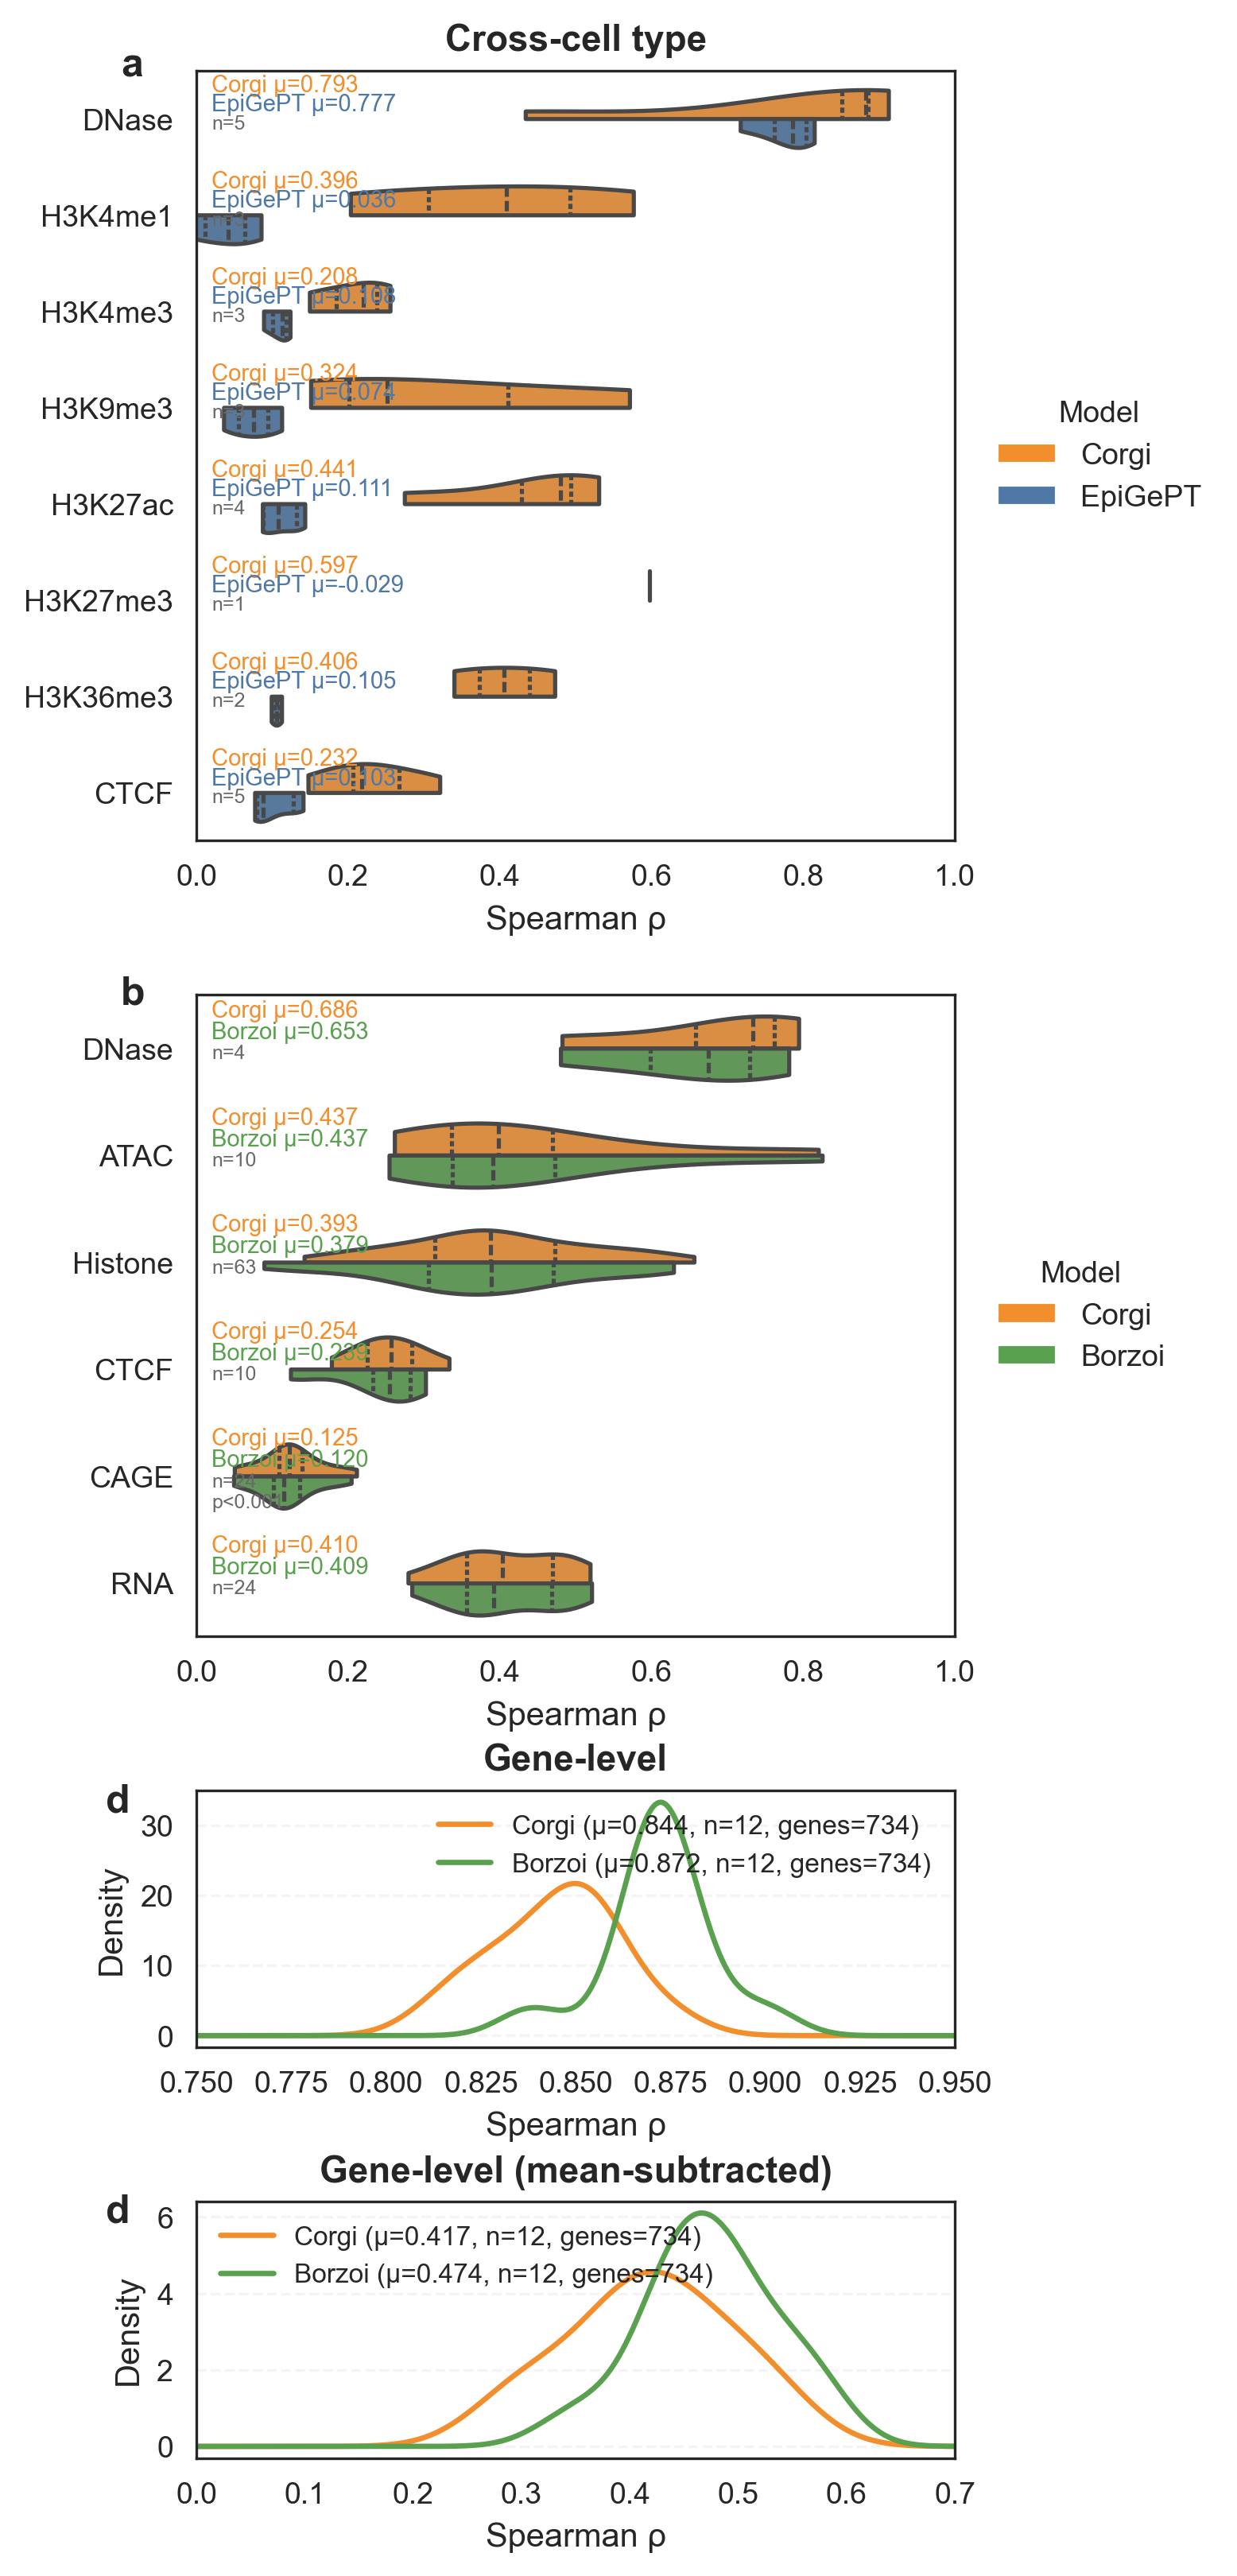

In [65]:
figsize = (4,13)
dpi = 300
output_pdf = '/project/deeprna/figures/revision/fig3/fig3.pdf'
output_png = None

fig = plt.figure(figsize=figsize, dpi=dpi)
gs = fig.add_gridspec(nrows=4, ncols=1, height_ratios=[1.2, 1, 0.4, 0.4], hspace=0.32, wspace=0.22)

ax_a = fig.add_subplot(gs[0])  # Spearman Corgi vs EpiGePT
ax_b = fig.add_subplot(gs[2])  # Spearman Corgi vs Borzoi
ax_c = fig.add_subplot(gs[1])  # Gene level Corgi vs Borzoi
ax_d = fig.add_subplot(gs[3])  # Gene level ms

# ---- Panels a & b (Corgi vs EpiGePT) ----
draw_violin(ax_a, df1, ['Corgi', 'EpiGePT'], 'spearman', ['DNase', 'H3K4me1', 'H3K4me3', 'H3K9me3', 'H3K27ac', 'H3K27me3', 'H3K36me3', 'CTCF'], MODEL_COLORS)
ax_a.set_title("Cross-cell type", loc='center', fontsize=11, fontweight='semibold')
ax_a.set_xlabel("Spearman ρ")
ax_a.set_ylabel("")
ax_a.text(-0.10, 1.03, 'a', transform=ax_a.transAxes, fontsize=12, fontweight='bold', va='top')

draw_violin(ax_c, df2, ['Corgi', 'Borzoi'], 'spearman', ['DNase', 'ATAC', 'Histone', 'CTCF', 'CAGE', 'RNA'], MODEL_COLORS)
ax_c.text(-0.10, 1.03, 'b', transform=ax_c.transAxes, fontsize=12, fontweight='bold', va='top')
ax_c.set_xlabel("Spearman ρ")
ax_c.set_ylabel("")

handles_ab = [Patch(facecolor=MODEL_COLORS['Corgi'], label='Corgi'),
              Patch(facecolor=MODEL_COLORS['EpiGePT'], label='EpiGePT')]
ax_a.legend(handles=handles_ab, title='Model', frameon=False, bbox_to_anchor=(1.02, 0.5), loc='center left', fontsize=9)

handles_cd = [Patch(facecolor=MODEL_COLORS['Corgi'], label='Corgi'),
              Patch(facecolor=MODEL_COLORS['Borzoi'], label='Borzoi')]
ax_c.legend(handles=handles_cd, title='Model', frameon=False, bbox_to_anchor=(1.02, 0.5), loc='center left', fontsize=9)

# ---- Panels b & d (Corgi vs Borzoi gene level) ----
# KDE lines with shared grid (global min->max) and legend includes sample size -----
ax_b.set_title("Gene-level", loc='center', fontsize=11, fontweight='semibold')
datasets = [('Corgi', corgi_cors), ('Borzoi', borzoi_cors)]
plotted = kde_shared_grid(ax_b, datasets, MODEL_COLORS, x_limits=(0.75, 0.95))
ax_b.set_xlabel('Spearman ρ')
ax_b.set_ylabel('Density')
ax_b.grid(axis='y', linestyle='--', alpha=0.2)
ax_b.text(-0.12, 1.03, 'd', transform=ax_b.transAxes, fontsize=12, fontweight='bold', va='top')
# Legend with mean R, sample size and n_genes
legend_texts = []
legend_texts.append(f"Corgi (μ={np.mean(corgi_cors):.3f}, n={len(corgi_cors)}, genes={coding_genes_corgi_nonzero.shape[0]})")
legend_texts.append(f"Borzoi (μ={np.mean(borzoi_cors):.3f}, n={len(borzoi_cors)}, genes={coding_genes_borzoi_nonzero.shape[0]})")
ax_b.legend(legend_texts, frameon=False, fontsize=8)

# MS
ax_d.set_title("Gene-level (mean-subtracted)", loc='center', fontsize=11, fontweight='semibold')
datasets = [('Corgi', ms_cors_corgi), ('Borzoi', ms_cors_borzoi)]
plotted = kde_shared_grid(ax_d, datasets, MODEL_COLORS, x_limits=(0, 0.7))
ax_d.set_xlabel('Spearman ρ')
ax_d.set_ylabel('Density')
ax_d.grid(axis='y', linestyle='--', alpha=0.2)
ax_d.text(-0.12, 1.03, 'd', transform=ax_d.transAxes, fontsize=12, fontweight='bold', va='top')
# Legend with mean R, sample size and n_genes
legend_texts = []
legend_texts.append(f"Corgi (μ={np.mean(ms_cors_corgi):.3f}, n={len(ms_cors_corgi)}, genes={coding_genes_corgi_nonzero_ms.shape[0]})")
legend_texts.append(f"Borzoi (μ={np.mean(ms_cors_borzoi):.3f}, n={len(ms_cors_borzoi)}, genes={coding_genes_borzoi_nonzero_ms.shape[0]})")
ax_d.legend(legend_texts, frameon=False, fontsize=8)


# ---- finalize & save ----
plt.tight_layout()
plt.subplots_adjust(right=0.92)

if output_pdf:
    os.makedirs(os.path.dirname(output_pdf), exist_ok=True)
    fig.savefig(output_pdf, bbox_inches='tight', dpi=dpi)
if output_png:
    os.makedirs(os.path.dirname(output_png), exist_ok=True)
    fig.savefig(output_png, bbox_inches='tight', dpi=dpi)

In [66]:
# Df1, pool all Corgi vs EpiGePT assays, do Wilcoxon test, add mean and n to plot
all_corgi = df1[df1['model'] == 'Corgi']['spearman'].values
all_epigept = df1[df1['model'] == 'EpiGePT']['spearman'].values
stat, p_val = wilcoxon(all_corgi, all_epigept)
print(f"Wilcoxon test for pooled Corgi vs EpiGePT assays: stat={stat:.3f}, p={p_val:.3e}, Corgi mean={np.mean(all_corgi):.3f}, EpiGePT mean={np.mean(all_epigept):.3f}, n={len(all_corgi)}")

Wilcoxon test for pooled Corgi vs EpiGePT assays: stat=18.000, p=7.540e-06, Corgi mean=0.426, EpiGePT mean=0.218, n=26
